# Spreading Out
Drop of food dye in a cup of water that slowly spreads in all directions until all of the liquid is the color of the dye.  Diffusion spreads it around but it is not directional.  We need numerical methods that are isotropic.

## Parabolic PDEs

1D Diffusion equation.  Main feature: Second-order derivative in space.
$$\frac{\partial u}{\partial t} = \alpha \frac{\partial ^2 u}{\partial x^2}$$

## Heat Conduction

Diffusive process.  Heat equation in one spatial dimension:
$$\frac{\partial T}{\partial t} = \alpha \frac{\partial ^2 T}{\partial x^2}$$

Where $\alpha$ is the thermal diffusivity which is a property of the material and $T$ is the temperature.

In Mod2_Les3 we discretized the diffusion equation with a forward time, and centered space scheme which was subject to the following stability constraint:
$$\alpha \frac{\Delta t}{(\Delta x)^2} \leq \frac{1}{2}$$

Gotta look at a 1D temperature evolution problem

### Problem set up

We have a graphite rod with a thermal diffusivity $\alpha = 1.22 x 10^{-3} m^2/s$ at length $L = 1m$ and temperature $T = 0^{\circ} C$ everywhere.  At time $t = 0$, we raise the temperature on the left-side end, $x = 0$ to $T = 100^{\circ} C$ and hold it there. How will the temperature evolve in the rod?

We will begin with a spatial grid of 51 points and using 100 time steps with a forward time/centered space scheme.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
#Initial Conditions
L = 1
nt = 100
nx = 51
alpha = 1.22e-3

dx = L/(nx-1)

Ti = numpy.zeros(nx)
Ti[0] = 100

Forward-time, Centered-space discretization
$$\frac{T_i ^{n+1} - T_i ^n}{\Delta t} = \alpha \frac{T_{i+1} ^n - 2T_i ^n + T_{i-1} ^n}{\Delta x^2}$$

To obtain the temperature at the next time step $T_i ^{n+1}$ from the known information at the current time step we get:
$$T_i ^{n+1} = T_i ^n + \frac{\alpha \Delta t}{\Delta x^2} (T_{i+1} ^n - 2T_i ^n + T_{i-1} ^n)$$

In [3]:
def ftcs(T, nt, dt, dx, alpha):
    """Solves the diffusion equation with forward-time, centererd scheme
    
    Parameters
    ----------
    T : array of float
        Initial temperature profile
    nt : int
        Number of time steps
    dt : float
        Time step size
    dx : float
        Mesh size
    alpha : float
        Diffusion coefficient (thermal diffusivity)
        
    Returns:
    -------
    T : array of float
        Temperature profile after nt time steps with a forward in the time scheme
    """
    for n in range(nt):
        Tn = T.copy()
        T[1:-1] = Tn[1:-1] + alpha * dt / dx ** 2 * (Tn[2:] - 2 * Tn[1:-1] + Tn[0:-2])
        
    return T

In [4]:
sigma = 1/2.0
dt = sigma * dx * dx / alpha
T = ftcs(Ti.copy(), nt, dt, dx, alpha)

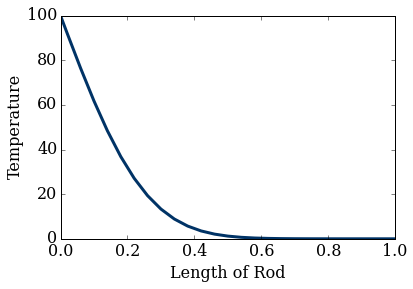

In [5]:
pyplot.plot(numpy.linspace(0, 1, nx), T, color = '#003366', ls = '-', lw = 3)
pyplot.ylim(0, 100)
pyplot.xlabel('Length of Rod')
pyplot.ylabel('Temperature');

## Boundary Conditions

We stated that the left-hand side of the rod is held to a temp of $T = 100^{\circ} C$.  This is an example of a boundary condition which is a rule that defines how the problem interacts with the borders of the domain.  In the case of this problem the domain spans the length of the rod from $0 \leq x \leq 1$

### Dirichlet Boundary

The rod example uses a Dirichlet BC on the left hand side.

**Dirlichlet boundary** : the border is held to a specific value of the solution variable.

What about the ride hand end?  In the discretization we set up the problem hasn't evolved for long enough time for the heat to travel the full length of the rod.  Let's increase the number of timesteps and see what hip-happens.

In [6]:
nt = 1000
T = ftcs(Ti.copy(), nt, dt, dx, alpha)

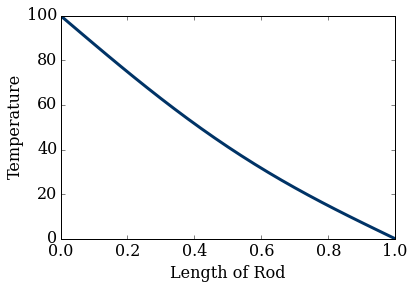

In [7]:
pyplot.plot(numpy.linspace(0, 1, nx), T, color = '#003366', ls = '-', lw = 3)
pyplot.ylim(0, 100)
pyplot.xlabel('Length of Rod')
pyplot.ylabel('Temperature');

We're pinning to the right BC to the value $T = 0^{\circ} C$

This is because the value at $T[-1]$ never is updated which in the initial Ti array is set to zero and always stays zero.  This effectively creates a Dirichlet boundary at both ends.  Due to this, after enough time the distribution will 'relax' to a linear temperature gradient across the length of the rod.

Once it is relaxed, no addition of timesteps will make it change.  This is an example of a steady-state solution.

Dirichlet BCs show up in lots of engineering applications such as thermodynamics (setting a surface temp), and fluid dynamics (no-slip conditions at walls in viscous fluids).

### Neumann boundary

Another type of BC which specifies the derivative of the solution at the border rather than a specific value.

In our example we can represent our Neumann boundary to the right hand end of the rod mathematically as:
$$\left. \frac{\partial T}{\partial x} \right|_{x = 1} = q(t)$$

We can turn that into code using a finite-difference discretization of the derivative at the boundary.  At time step n, for N points:

$$\left. \frac{\partial T}{\partial x} \right|_{x = 1} \approx \frac{T_N ^n - T_{N-1} ^n}{\Delta x} = q(t)$$

The space derivative of the temperature is the heat flux density $q$ which is the amount of heat per unit time, per unit area.

For example, if at x = 1 on the rod there is insulating material, no heat is going to be able to get out through that end, and the Neumann boundary condition is:

$$\left. \frac{\partial T}{\partial x} \right|_{x = 1} = 0$$

This means that the change in temperature when moving in the x direction is zero at the right most edge of the rod, meaning that the temperature should be equal on the last two spatial grid points.

To enforce this BC at the right hand end of the rode we add this to our code:

$$T[-1] = T[-2]$$

This means the temperature at the boundary $T[-1]$ is equal to the temperature directly to its left $T[-2]$.  The spatial gradient is zero and a Neumann condition is satisfied there.

The Dirichlet conditions did not need any extra input, but the Neumann condition requires an update at each iteration of the loop.

Sometimes Dirichlet and Neumann BCs can be mixed to better represent the physics of a problem.

For the problem now at $x = 0$ the temp will be fixed at $T = 100^{\circ} C$ - Dirichlet condition and a Neumann BC at $x = 1$

In [8]:
def ftcs_mixed(T, nt, dt, dx, alpha):
    """Solves the diffusion equation with forward-time, centered scheme using Dirichlet BC at the left boundary and Neumann BC at the right boundary
    
    Parameters:
    ----------
    u : array of float
        Initial temperature profile
    nt : int
        Number of time steps
    dt : float
        Time step size
    dx : float
        Mesh size
    alpha : float
        Diffusion coefficient (thermal diffusivity)
        
    Returns:
    -------
    u : array of float
        Temperature profile after nt time steps with forward in time scheme
    """
    
    for n in range(nt):
        Tn = T.copy()
        T[1:-1] = Tn[1:-1] + alpha * dt / dx ** 2 * (Tn[2:] - 2 * Tn[1:-1] + Tn[0:-2])
        T[-1] = T[-2]
        
    return T

In [15]:
nt = 1000
T = ftcs_mixed(Ti.copy(), nt, dt, dx, alpha)

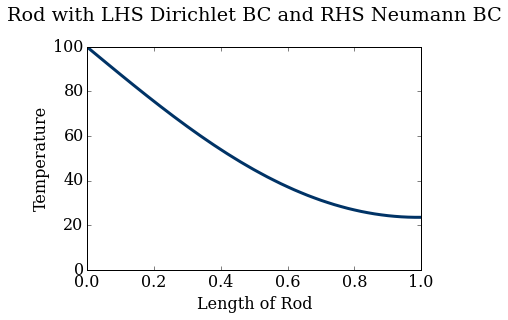

In [16]:
pyplot.plot(numpy.linspace(0, 1, nx), T, color = '#003366', ls = '-', lw = 3)
pyplot.ylim(0, 100)
pyplot.title('Rod with LHS Dirichlet BC and RHS Neumann BC \n')
pyplot.xlabel('Length of Rod')
pyplot.ylabel('Temperature');

### Explicit schemes and BCs

The numerical schemes we have used so far are called explicit because we compute the updated solution at $t^{n+1}$ using only known information at $t^n$. It has limitations mostly with the small size of time steps necessary to obtain stability.

Another issue is that at the boundary, any change will feed into the  solution only at the next time step, not immediately.  This contradicts the physics of the problem, because any change on the boundary should be felt right away under the diffusion equation.

To include boundary effects an implicit update is used.